In [122]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from matplotlib.patches import Rectangle
from scipy.sparse.linalg import eigs

from Interviews.KronosAI.waveguide import core_width


In [123]:
params = {
    'waveguide': {
        'core_width' : 450e-9,
        'core_height' : 220e-9,
        'n_Si': 3.48,
        'n_SiO2': 1.44,
    },
    'domain': {
        'width': 3e-6,
        'height': 2e-6,
        'dx': 10e-9,
        'dy': 10e-9,
    },
    'wavelength': {
        'sweep_min': 1300e-9,
        'sweep_max': 1600e-9,
        'sweep_points': 10,
    },
        'sweep': {
        'n_modes': 10,
    },
    'solver': {
        'target_delta': 1.0,
    }

}


In [124]:

def first_derivative_1d(n, d):
    """Central-difference 1D derivative matrix (size n×n, spacing d)."""
    off = 0.5 / d
    data = [-off * np.ones(n-1), np.zeros(n), off * np.ones(n-1)]
    return sp.diags(data, offsets=(-1, 0, 1))

def second_derivative_1d(n, d):
    """Central 2nd‐derivative: +1/d² on ±1, –2/d² on diag."""
    diag = -2.0 * np.ones(n)
    off  =  1.0 * np.ones(n-1)
    return sp.diags([off, diag, off], offsets=(-1,0,1)) / d**2

def build_derivative_operators(nx, ny, dx, dy):
    """
    Returns two sparse matrices Dx, Dy of shape (nx*ny, nx*ny) that
    approximate ∂/∂x and ∂/∂y on a tensor grid.
    """
    Dx1 = first_derivative_1d(nx, dx)
    Dy1 = first_derivative_1d(ny, dy)
    Dx = sp.kron(sp.eye(ny), Dx1)   # ∂/∂x
    Dy = sp.kron(Dy1, sp.eye(nx))   # ∂/∂y
    return Dx, Dy


In [125]:


def wavelength_sweep(core_width, core_height, n_core, n_clad, wavelengths, n_modes=2, params=None):
    width  = params['domain']['width']
    height = params['domain']['height']
    dx     = params['domain']['dx']
    dy     = params['domain']['dy']


    n_effs = np.full((len(wavelengths), n_modes), np.nan)

    solver = WaveguideModeSolver(width, height, dx, dy, wavelengths[0], n_modes=n_modes, params=params)
    solver.add_rectangle(-core_width/2, core_width/2, -core_height/2, core_height/2,
                             n_core, n_clad)

    for i, wl in enumerate(wavelengths):
        print(f"Solving for wavelength {wl*1e9:.1f} nm")

        solver.update_wavelength(wl)
        neffs = solver.solve()

        print(f"Found {len(neffs)} modes with n_eff values {[f'{n.real:.6f}' for n in neffs]}")  # now returns 1D array
        for j in range(min(len(neffs), n_modes)):
            n_effs[i, j] = np.real(neffs[j])

    return wavelengths, n_effs



In [126]:
class WaveguideModeSolver:
    def __init__(self, width, height, dx, dy, wavelength, n_modes, params):
        self.width = width
        self.height = height
        self.dx = dx
        self.dy = dy
        self.wavelength = wavelength
        self.n_modes = n_modes
        self.params = params
        self.epsilon0 = 8.8541878128e-12
        self.c = 299792458.0
        self.mu0 = 4e-7 * np.pi

        self.nx = int(width/self.dx)
        self.ny = int(height/self.dy)

        self.Dx, self.Dy = build_derivative_operators(self.nx, self.ny, self.dx, self.dy)
        self.update_wavelength(wavelength)

        self.epsilon_r = np.ones((self.ny, self.nx))

        self.x = np.linspace(-self.width/2, self.width/2, self.nx)
        self.y = np.linspace(-self.height/2, self.height/2, self.ny)
        self.xx, self.yy = np.meshgrid(self.x, self.y)

        self.waveguide_regions = []

    def update_wavelength(self, wavelength):
        self.wavelength = wavelength
        self.k0 = 2 * np.pi / self.wavelength


    def add_rectangle(self, x_min, x_max, y_min, y_max, n_core, n_clad):
        i_min = int((x_min + self.width/2) / self.dx)
        i_max = int((x_max + self.width/2) / self.dx)
        j_min = int((y_min + self.height/2) / self.dy)
        j_max = int((y_max + self.height/2) / self.dy)

        i_min = max(0, i_min)
        i_max = min(self.nx, i_max)
        j_min = max(0, j_min)
        j_max = min(self.ny, j_max)

        self.epsilon_r[:, :] = n_clad ** 2
        self.epsilon_r[j_min:j_max, i_min:i_max] = n_core ** 2

        self.waveguide_regions.append({
            'x_min': x_min,
            'x_max': x_max,
            'y_min': y_min,
            'y_max': y_max,
            'n_core': n_core,
            'n_clad': n_clad,
        })



    def solve(self, target_delta=None):
        """
        Solve the full-vector 2D Maxwell eigenproblem (curl-curl) for guided modes.
        Populates self.n_eff, self.E_fields, self.Hz_fields, and self.energy_density.
        Returns:
            self.n_eff (array of guided effective indices)
        """
        # --- constants and grid ---
        c    = self.c
        mu0  = self.mu0
        eps0 = self.epsilon0
        omega = 2 * np.pi * c / self.wavelength
        k0    = self.k0
        nx, ny = self.nx, self.ny
        N      = nx * ny

        # --- material params ---
        eps_r    = self.epsilon_r
        eps_phys = eps_r.flatten()
        n_core   = np.sqrt(np.max(eps_r))
        n_clad   = np.sqrt(np.min(eps_r))

        if target_delta is None:
            target_delta = self.params.get('solver', {}).get('target_delta', 1.0)


        Dxx = second_derivative_1d(nx, self.dx)
        Dyy = second_derivative_1d(ny, self.dy)
        L = sp.kron(sp.eye(ny), Dxx) + sp.kron(Dyy, sp.eye(nx))
        A11 = L + k0 ** 2 * sp.diags(eps_phys)

        B11 = sp.eye(N)

        boundary = np.zeros(N, dtype=bool)
        # top & bottom rows
        boundary[0:   self.nx] = True
        boundary[-self.nx:]    = True
        # left & right columns
        boundary[::self.nx]        = True
        boundary[self.nx-1::self.nx] = True

        A11_lil = A11.tolil()
        B11_lil = B11.tolil()

        # apply to A11
        for idx in np.where(boundary)[0]:
            A11_lil[idx, :] = 0
            A11_lil[idx, idx] = 1
            B11_lil[idx, :] = 0
            B11_lil[idx, idx] = 1

        A11 = A11_lil.tocsr()
        B11 = B11_lil.tocsr()

        A = sp.bmat([[A11, None],
                 [None, A11]], format="csr")
        B = sp.bmat([[B11, None],
                 [None, B11]], format="csr")

        n_eff_target = n_core - target_delta
        beta_target = n_eff_target * k0
        sigma = beta_target ** 2

        eigvals, eigvecs = eigs(A, M=B, k=self.n_modes, sigma=sigma, which='LM')
        beta = np.sqrt(eigvals + 0j)
        n_effs = beta / k0
        order = np.argsort(-np.real(n_effs))
        n_effs = n_effs[order]
        eigvecs = eigvecs[:, order]

        valid_indices = []

        if len(n_effs) > 0:
            if 0.5 * n_clad < np.real(n_effs[0]) < 1.5 * n_core and np.abs(np.imag(n_effs[0])) < 0.1:
                valid_indices.append(0)

        for idx, n_eff in enumerate(n_effs[1:3], 1):
            if idx not in valid_indices:
                if n_clad * 0.9 < np.real(n_eff) < n_clad * 1.1 and np.abs(np.imag(n_eff)) < 2e-2:
                    valid_indices.append(idx)

        # filtering for other modes
        for idx, n_eff in enumerate(n_effs):
            if idx not in valid_indices:
                if n_clad < np.real(n_eff) < n_core:
                    if np.abs(np.imag(n_eff)) < 1e-3:
                        valid_indices.append(idx)

        guided_indices = np.array(valid_indices)

        if guided_indices.size == 0:
            # no modes passed the threshold → take the top n_modes anyway
            # print error
            ...
        else:
            sorted_indices = guided_indices[np.argsort(-np.real(n_effs[guided_indices]))]
            guided_indices = sorted_indices[: self.n_modes]
            self.n_eff = n_effs[guided_indices]
        # --- reshape into Ex, Ey ---
          # ─── 1D→2D reshape (still row‐major/C‐order by default) ─────────────────────────
        self.E_fields = []
        Dx_2D = lambda field: self.Dx.dot(field.flatten()).reshape(self.ny, self.nx)
        Dy_2D = lambda field: self.Dy.dot(field.flatten()).reshape(self.ny, self.nx)
        for mode_idx in guided_indices:
            vec = eigvecs[:, mode_idx]
            Ex = vec[:N].reshape((self.ny, self.nx))
            Ey = vec[N:].reshape((self.ny, self.nx))

            core_mask = eps_r > (n_clad ** 2 + 1e-6)
            core_power = np.sum(eps_r[core_mask] * (np.abs(Ex[core_mask])  ** 2
                                                    + np.abs(Ey[core_mask]) ** 2)) * self.dx * self.dy
            total_power = np.sum(eps_r * (np.abs(Ex) ** 2 + np.abs(Ey) ** 2)) * self.dx * self.dy
            core_percentage = core_power / total_power * 100 if total_power > 0 else 0
            print(f"Mode {mode_idx}: core power: {core_percentage:.2f}%")

            Ex /= np.sqrt(total_power)
            Ey /= np.sqrt(total_power)

            self.E_fields.append((Ex, Ey))

        # --- reconstruct Hz and compute energy density ---
        self.Hz_fields = []
        self.energy_density = []
        for Ex, Ey in self.E_fields:
            dEy_dx = Dx_2D(Ey)
            dEx_dy = Dy_2D(Ex)
            Hz = (1.0/(1j * omega * mu0)) * (dEy_dx - dEx_dy)
            self.Hz_fields.append(Hz)

            electric = 0.5 * eps0 * eps_r * (np.abs(Ex)**2 + np.abs(Ey)**2)
            magnetic = 0.5 * mu0  * np.abs(Hz)**2
            self.energy_density.append(electric + magnetic)

        return self.n_eff


    def plot_vectorial_mode(self, mode_idx, title_suffix=""):
        """
        Plot Ex, Ey, Hz and total energy density W for mode `mode_idx`.
        """
        Ex, Ey = self.E_fields[mode_idx]
        Hz    = self.Hz_fields[mode_idx]
        W     = self.energy_density[mode_idx]

        # Convert to µm for axes
        X = self.x * 1e6
        Y = self.y * 1e6
        extent = [X[0], X[-1], Y[0], Y[-1]]

        fig, axs = plt.subplots(2, 2, figsize=(10, 8))

        im0 = axs[0,0].imshow(np.real(Ex), extent=extent, origin='lower', cmap='RdBu')
        axs[0,0].set_title(f"Re(Ex) {title_suffix}")
        plt.colorbar(im0, ax=axs[0,0])

        im1 = axs[0,1].imshow(np.real(Ey), extent=extent, origin='lower', cmap='RdBu')
        axs[0,1].set_title(f"Re(Ey) {title_suffix}")
        plt.colorbar(im1, ax=axs[0,1])

        im2 = axs[1,0].imshow(np.abs(Hz), extent=extent, origin='lower', cmap='inferno')
        axs[1,0].set_title(f"|Hz| {title_suffix}")
        plt.colorbar(im2, ax=axs[1,0])

        im3 = axs[1,1].imshow(W, extent=extent, origin='lower', cmap='plasma')
        axs[1,1].set_title(f"Energy density W {title_suffix}")
        plt.colorbar(im3, ax=axs[1,1])

        for ax in axs.flat:
            ax.set_xlabel('x (µm)')
            ax.set_ylabel('y (µm)')
            self._add_waveguide_overlay(ax)

        plt.tight_layout()
        plt.show()

    def _add_waveguide_overlay(self, ax):
        for region in self.waveguide_regions:
            x_min = region['x_min'] * 1e6
            x_max = region['x_max'] * 1e6
            y_min = region['y_min'] * 1e6
            y_max = region['y_max'] * 1e6

            rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             fill=False, edgecolor='lime', linestyle='--', linewidth=1.5)

            ax.add_patch(rect)



In [127]:
def main():
    waveguide_params = params['waveguide']
    domain_params = params['domain']
    wavelength_params = params['wavelength']
    sweep_params = params['sweep']
    # solver_params = params['solver']

    core_width = waveguide_params['core_width']
    core_height = waveguide_params['core_height']
    n_Si = waveguide_params['n_Si']
    n_SiO2 = waveguide_params['n_SiO2']

    width = domain_params['width']
    height = domain_params['height']
    dx = domain_params['dx']
    dy = domain_params['dy']

    wl_min = wavelength_params['sweep_min']
    wl_max = wavelength_params['sweep_max']
    wl_points = wavelength_params['sweep_points']

    n_modes = sweep_params['n_modes']



    # Create and run the sweep
    wavelengths = np.linspace(wl_min, wl_max, wl_points)
    wl_sweep, n_effs_sweep = wavelength_sweep(core_width, core_height,
                                             n_Si, n_SiO2,
                                             wavelengths,
                                             n_modes=n_modes,
                                             params=params)

    plt.figure(figsize=(10, 6))

    mode0_valid = ~np.isnan(n_effs_sweep[:, 0])
    plt.plot(wl_sweep[mode0_valid] * 1e9, n_effs_sweep[mode0_valid, 0], 'o-', color='blue',
             linewidth=3, markersize=10, label='Mode 0 (TE0)')

    mode1_valid = ~np.isnan(n_effs_sweep[:, 1])
    plt.plot(wl_sweep[mode1_valid] * 1e9, n_effs_sweep[mode1_valid, 1], '^--', color='cyan',
             linewidth=2, markersize=8, label='Mode 1 (TM0)')

    mode2_valid = ~np.isnan(n_effs_sweep[:, 2])
    plt.plot(wl_sweep[mode2_valid] * 1e9, n_effs_sweep[mode2_valid, 2], 'o-', color='red',
             linewidth=3, markersize=10, label='Mode 2 (TE1)')

    mode3_valid = ~np.isnan(n_effs_sweep[:, 3])
    plt.plot(wl_sweep[mode3_valid] * 1e9, n_effs_sweep[mode3_valid, 3], '^--', color='orange',
             linewidth=2, markersize=8, label='Mode 3 (TM1)')

    mode4_valid = ~np.isnan(n_effs_sweep[:, 4])
    plt.plot(wl_sweep[mode4_valid] * 1e9, n_effs_sweep[mode4_valid, 4], 'o-', color='green',
             linewidth=2, markersize=8, label='Mode 4 (TE2)')

    plt.xlabel('Wavelength (nm)', fontsize=16)
    plt.ylabel('Effective index', fontsize=16)
    plt.legend(fontsize=14, loc='best')
    plt.grid(True)
    plt.title('Guided modes effective index vs wavelength', fontsize=18)
    plt.tight_layout()
    plt.show()

    # Plot the vectorial fields at specific wavelengths
    for wl in [1310e-9, 1550e-9]:
        solver_n_modes = max(5, n_modes)
        solver = WaveguideModeSolver(width, height, dx, dy, wl, n_modes=solver_n_modes, params=params)
        solver.add_rectangle(-core_width / 2, core_width / 2, -core_height / 2, core_height / 2,
                             n_Si, n_SiO2)

        neffs = solver.solve()
        for i in range(min(5, len(neffs))):
            mode_type = "TE0" if i == 0 else "TM0" if i == 1 else "TE1" if i == 2 else "TM1"  if i==3 else "TE2"
            solver.plot_vectorial_mode(i, title_suffix=f'{mode_type}, n_eff={neffs[i].real:.2f} at {wl*1e9:.0f}nm')

Solving for wavelength 1300.0 nm
Mode 0: core power: 96.68%
Mode 1: core power: 96.68%
Mode 2: core power: 93.17%
Mode 3: core power: 93.17%
Found 4 modes with n_eff values ['2.778093', '2.778093', '2.126249', '2.126249']
Solving for wavelength 1333.3 nm
Mode 0: core power: 96.47%
Mode 1: core power: 96.47%
Mode 2: core power: 92.53%
Mode 3: core power: 92.53%
Found 4 modes with n_eff values ['2.753026', '2.753026', '2.070835', '2.070835']
Solving for wavelength 1366.7 nm
Mode 0: core power: 96.25%
Mode 1: core power: 96.25%
Mode 2: core power: 91.83%
Mode 3: core power: 91.83%
Found 4 modes with n_eff values ['2.727936', '2.727936', '2.015085', '2.015085']
Solving for wavelength 1400.0 nm
Mode 0: core power: 96.02%
Mode 1: core power: 96.02%
Mode 2: core power: 91.07%
Mode 3: core power: 91.07%
Found 4 modes with n_eff values ['2.702834', '2.702834', '1.959078', '1.959078']
Solving for wavelength 1433.3 nm
Mode 0: core power: 95.79%
Mode 1: core power: 95.79%
Mode 2: core power: 90.23

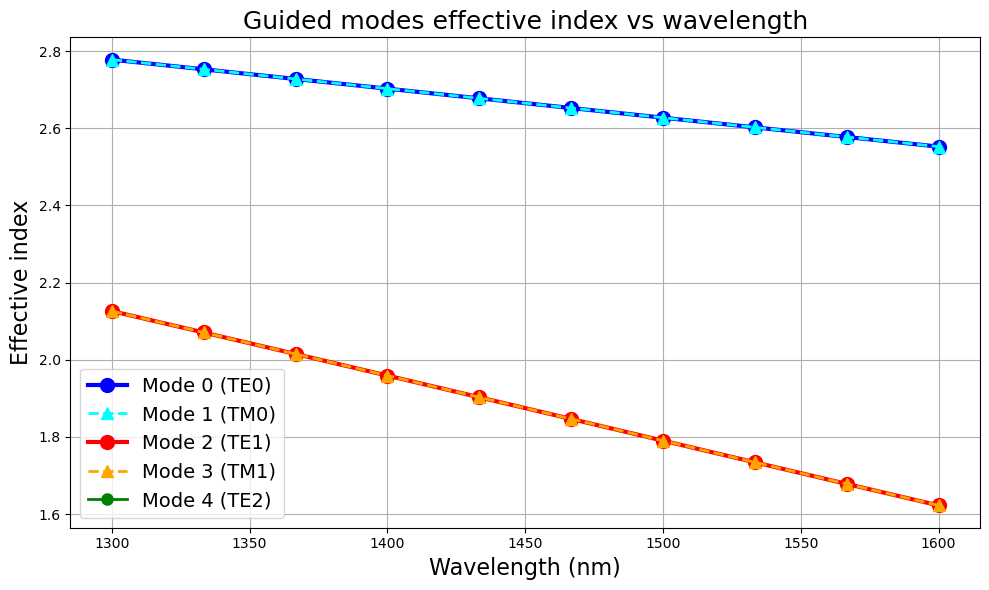

Mode 0: core power: 96.61%
Mode 1: core power: 96.61%
Mode 2: core power: 92.98%
Mode 3: core power: 92.98%


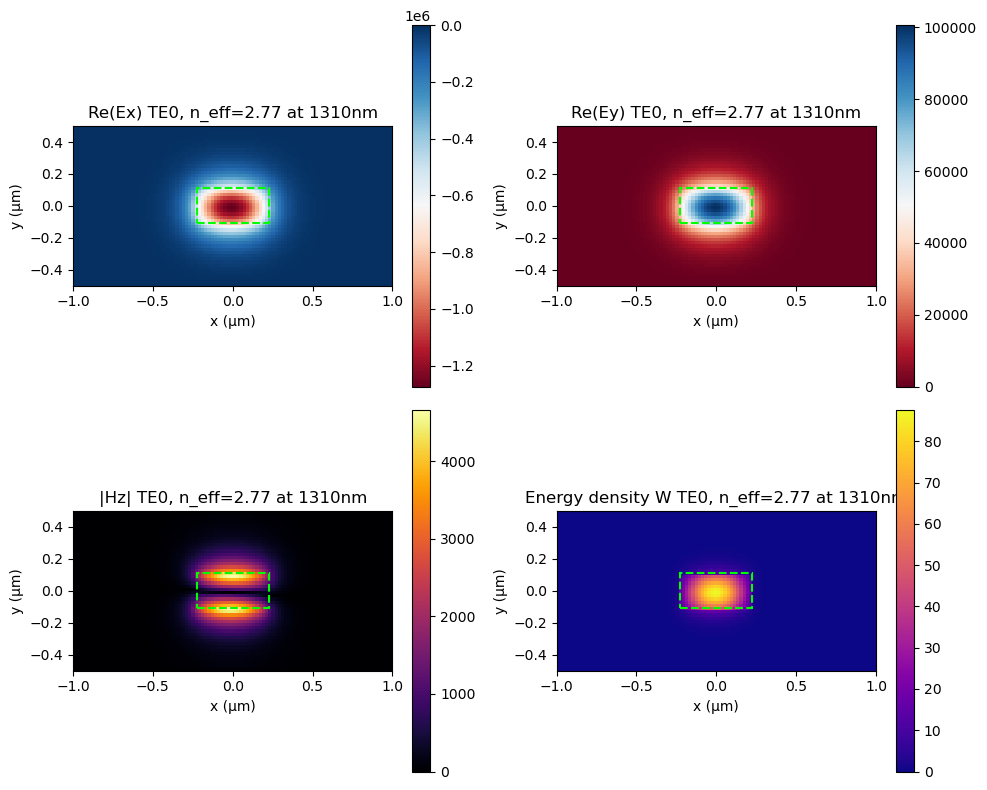

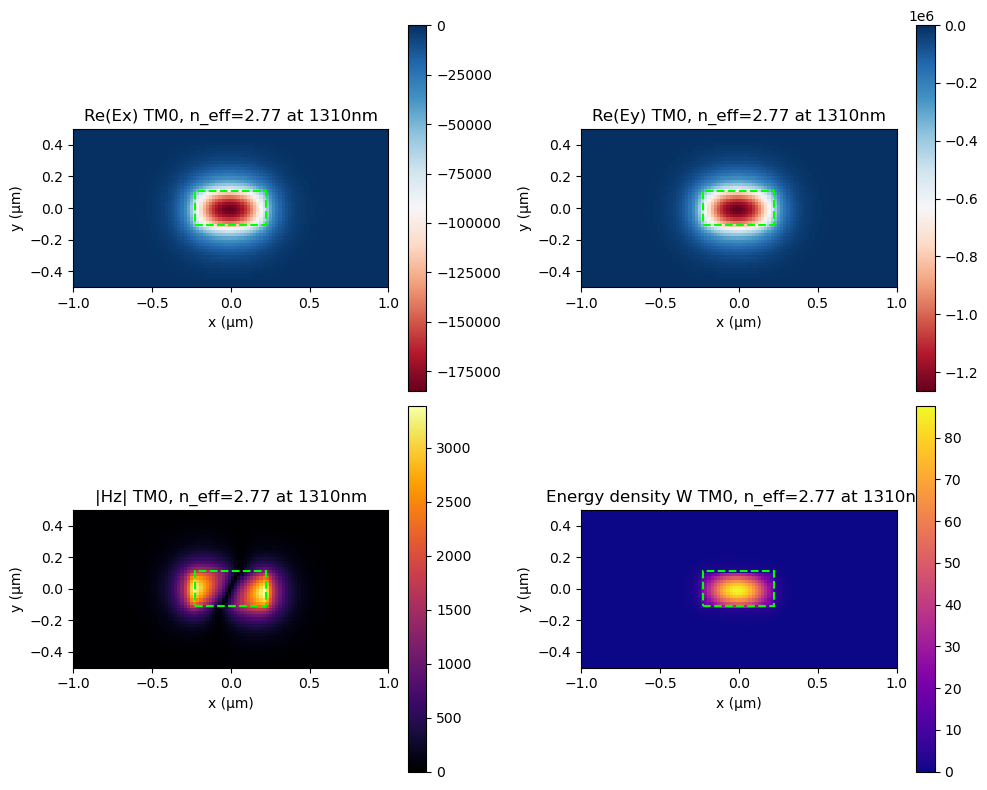

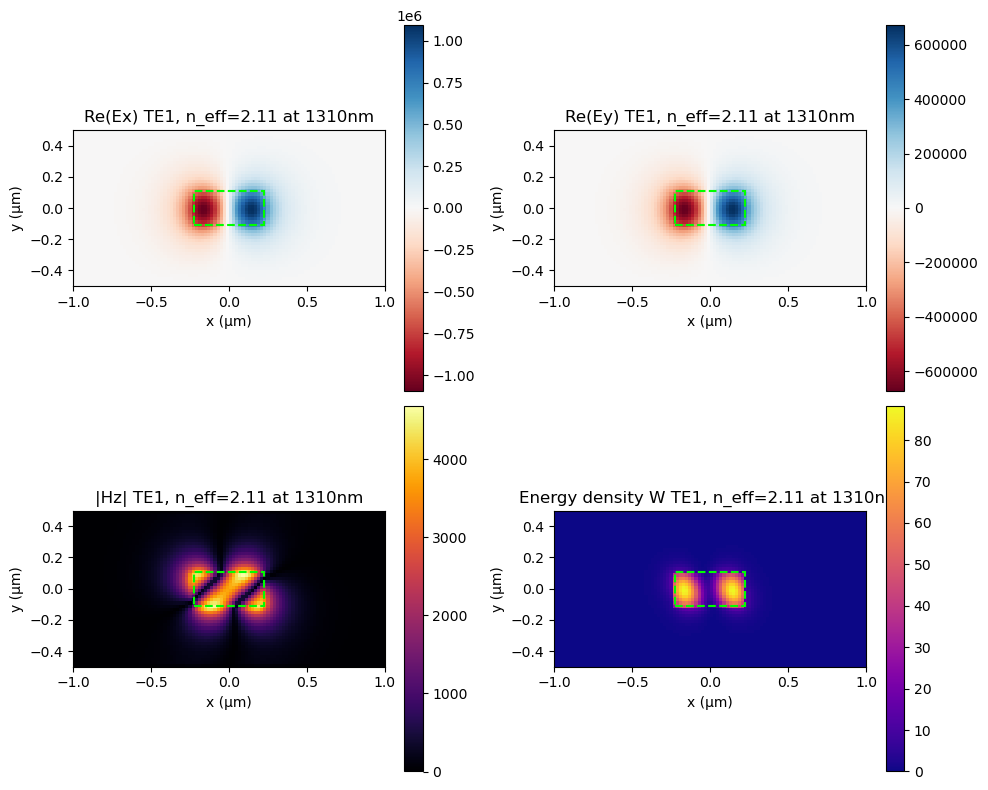

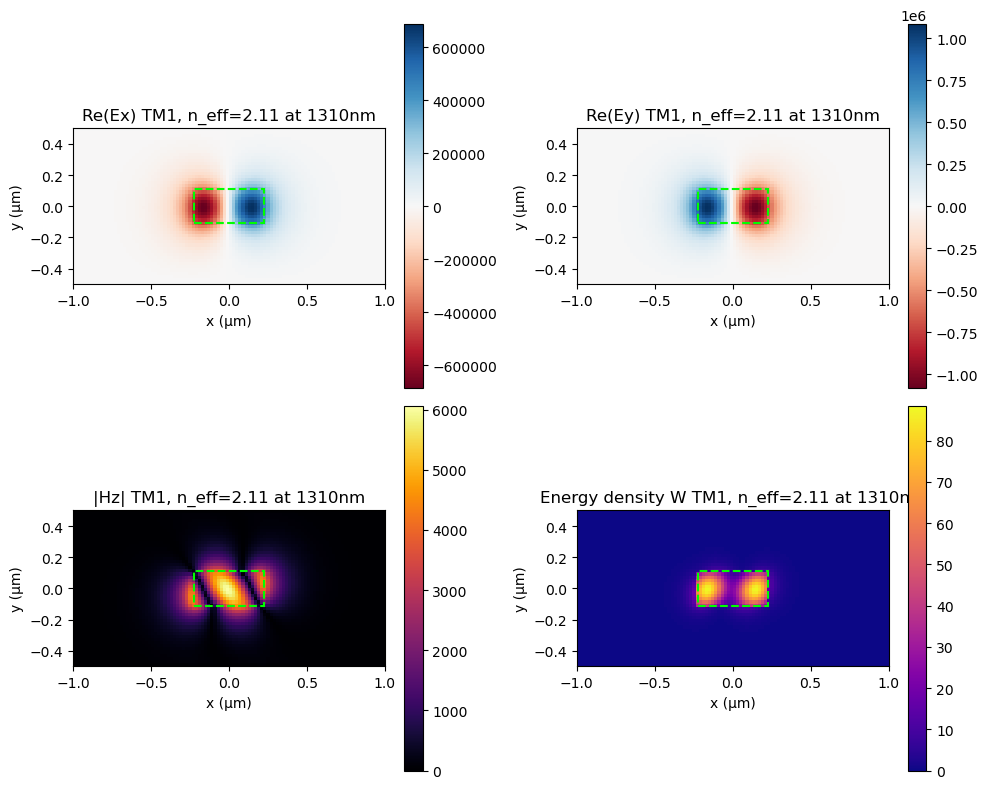

Mode 0: core power: 94.92%
Mode 1: core power: 94.92%
Mode 2: core power: 86.63%
Mode 3: core power: 86.63%


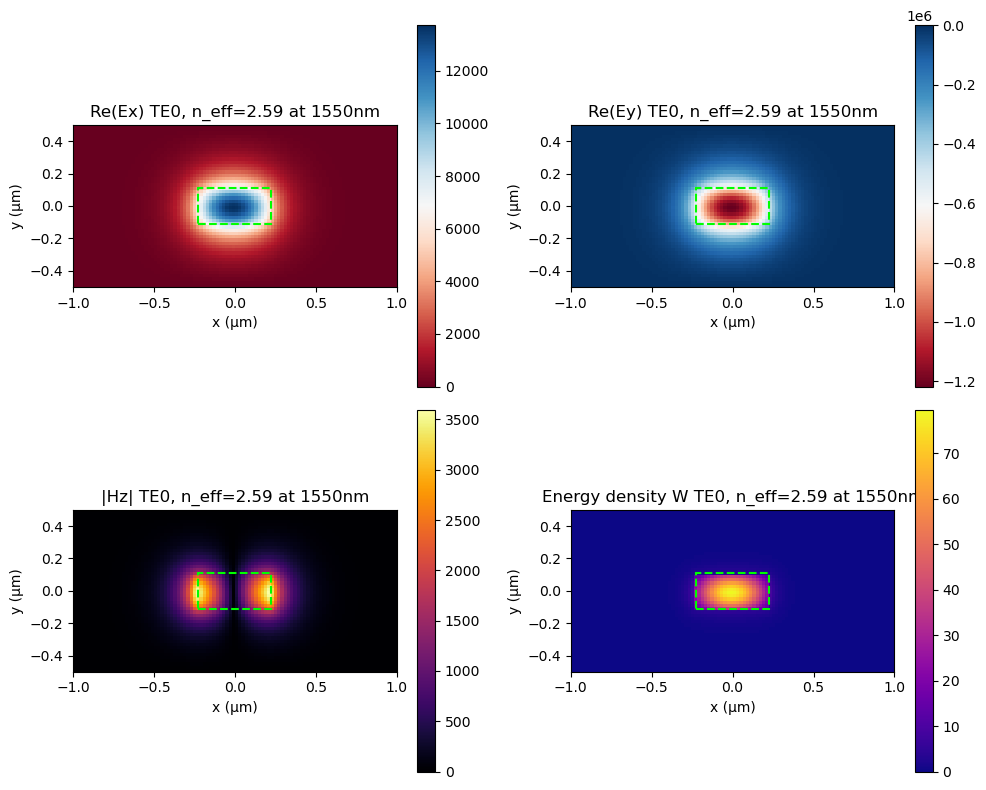

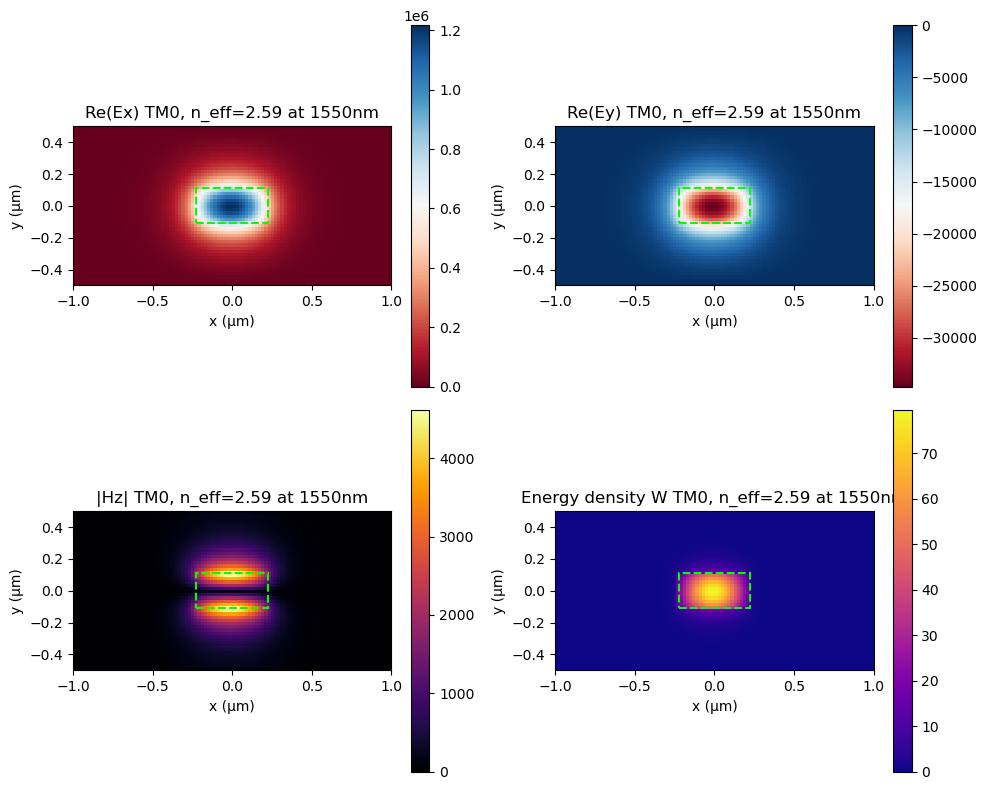

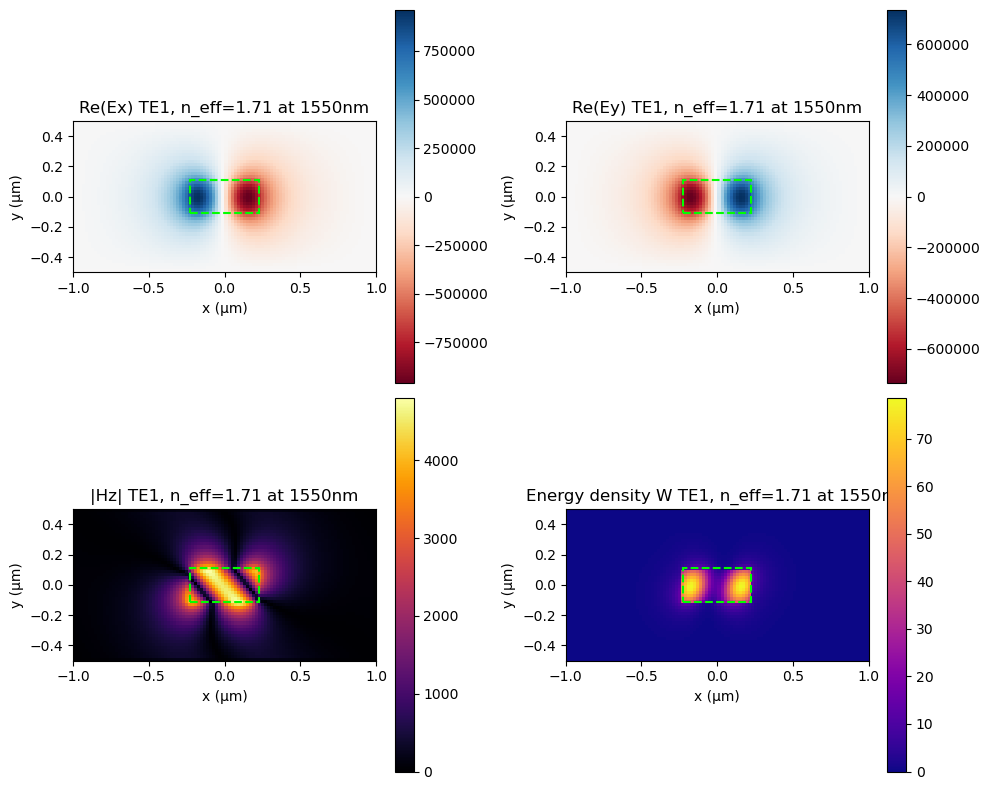

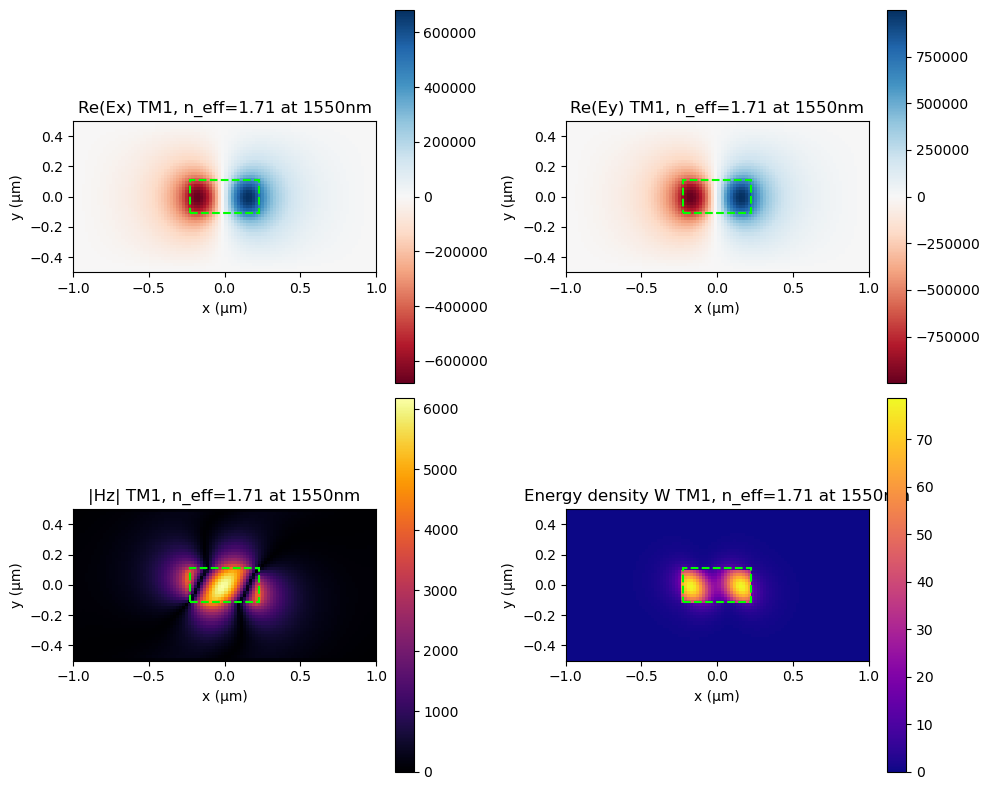

In [128]:
main()